# Modeling Coupling

## Exampling - Grain growth with Zener pinning

There are three ways to couple two models in kawin. We'll show this by coupling a KWN model with a grain growth model, where grain growth is inhibited by Zener pinning.

First let's set up the two models.

The first model is the KWN model with the Al-Sc system that was used in the Strength Modeling example.

In [1]:
from kawin.thermo import BinaryThermodynamics
from kawin.precipitation import PrecipitateModel, VolumeParameter
import numpy as np

therm = BinaryThermodynamics('AlScZr.tdb', ['AL', 'SC'], ['FCC_A1', 'AL3SC'])
therm.setGuessComposition(0.24)

precModel = PrecipitateModel()

precModel.setInitialComposition(0.002)
precModel.setTemperature(400+273.15)
precModel.setInterfacialEnergy(0.1)

Va = (0.405e-9)**3
Vb = (0.4196e-9)**3
precModel.setVolumeAlpha(Va, VolumeParameter.ATOMIC_VOLUME, 4)
precModel.setVolumeBeta(Vb, VolumeParameter.ATOMIC_VOLUME, 4)

diff = lambda x, T: 1.9e-4 * np.exp(-164000 / (8.314*T)) 
precModel.setDiffusivity(diff)

precModel.setThermodynamics(therm, addDiffusivity=False)

The second model is a grain growth model with a grain size distribution (radius) following $ ln X = Normal(ln(1*10^{-6}), 0.2) $ with a grain boundary mobility of 1e-14 $m^4/Js$.

The grain growth model follows the implementation from K. Wu, J. Jeppson and P. Mason, J. Phase Equilib. Diffus. 43 (2022) 866-875. The growth rate of a grain of size $R_i$ is defined as:
$$ \frac{dR_i}{dt} = \alpha M \gamma \left(\frac{1}{R_{Cr}} - \frac{1}{R_i} \right) $$

Where $\alpha$ is a correction factor when fitting to experimental data, $M$ is the grain boundary mobility ($m^4/Js$) and $\gamma$ is the grain boundary energy ($J/m^2$). The default values for $\alpha$, $M$ and $\gamma$ are $1$, $1e{-14} m^4/Js$ and $0.5 J/m^2$ respectively.

To satisfy volume conservation, $R_{Cr}$ is defined as:
$$ R_{Cr} = \frac{\sum{n_i R_i^2}}{\sum{n_i R_i}} $$

With the average radius defined as:
$$ R_m = \left(\frac{\sum{n_i R_i^3}}{\sum{n_i}}\right)^{1/3} $$

Precipitates create a pinning force, which can be defined as the inverse of the Zener radius ($R_z$):
$$ z = \frac{1}{R_z} = \frac{1}{K} \frac{f^m}{r_{avg}} $$

Where $f$ and $r_{avg}$ is the volume fraction and average radius of the precipitates respectively. The terms $K$ and $m$ are values that correspond to the spatial distribution of precipitates in the alloy. By default, they are $4/3$ and $1$ respectively. For multi-phase systems, $z$ is calculated for each phase and summed together. Then $R_z$ is the inverse of the summed $z$.

The growth rate accounting for this pinning force is then defined as:
$$ \frac{dR_i}{dt} = \alpha M \gamma \left(\frac{1}{R_{Cr}} - \frac{1}{R_i} \pm \frac{1}{R_z} \right) $$

Where $\frac{1}{R_z}$ is subtracted if $\left(\frac{1}{R_{Cr}} - \frac{1}{R_i} - \frac{1}{R_z} \right)$ is greater than 0 (inhibiting grain growth), $\frac{1}{R_z}$ is added if $\left(\frac{1}{R_{Cr}} - \frac{1}{R_i} + \frac{1}{R_z} \right)$ is less than 0 (inhibiting grain dissolution), and $\frac{dR_i}{dt}$ is 0 between these two limits.

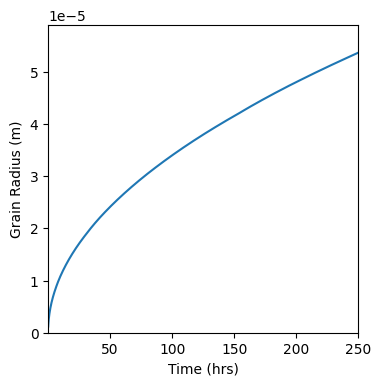

In [2]:
from kawin.precipitation.coupling.GrainGrowth import GrainGrowthModel
import matplotlib.pyplot as plt

grainModel = GrainGrowthModel(cMin=1e-10, cMax=0.5e-5)
grainModel.setGrainBoundaryMobility(1e-14)
data = np.random.lognormal(mean=np.log(1e-6), sigma=0.2, size=100000)
grainModel.LoadDistribution(data)

fig, ax = plt.subplots(1, 1, figsize=(4,4))

#Solve model for 250 hours to create a reference to unpinned grain growth
grainModel.solve(250*3600)
t_noPin = np.array(grainModel.time/3600)
r_noPin = np.array(grainModel.avgR)

grainModel.plotRadiusvsTime(ax, timeUnits='h')

### Method 1 - Loose Coupling

The easiest way to couple these two models is to solve each one seperately for a fixed amount of time and update the models with the new values. For our system, only the grain growth model needs information from the precipitate model. While easy to implement, this is a very loose couple and the fidelity of the coupling is dependent on the time interval before updating the models. Here, we use a fairly coarse step size with 50 steps on a log scale.

In [3]:
#Reset models
precModel.reset()
grainModel.reset()

#Set up an array of fixed times on a log scale up to 9e5 seconds
times = np.concatenate(([0], np.logspace(np.log10(9e0), np.log10(9e5), 50)))

for i in range(len(times)-1):
    precModel.solve(times[i+1] - times[i])
    grainModel.computeZenerRadius(precModel)
    grainModel.solve(times[i+1] - times[i])

Nucleation density not set.
Setting nucleation density assuming grain size of 100 um and dislocation density of 5e+12 #/m2


C:\Users\ury3\OneDrive - LLNL\Documents\Projects\U-C Modeling\kawin-development\kawin\kawin\precipitation\KWNBase.py:1162: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-tau / t)


While the un-pinned grain growth showed parabolic behavior, the pinned grain growth grows in a step-wise fashion growing very quickly, then plateauing, then growth quickly again. This occurs as the during the coarsening step, the grains will continue to growth until reaching the Zener radius, at which the growth rate will plateau. As the precipitate coarsens, the Zener radius increases (reducing the pinning force), allowing to grains to quickly grow and catch up to the Zener radius. This process will continue to repeat itself as the precipitates coarsen.

(0.0, 6e-05)

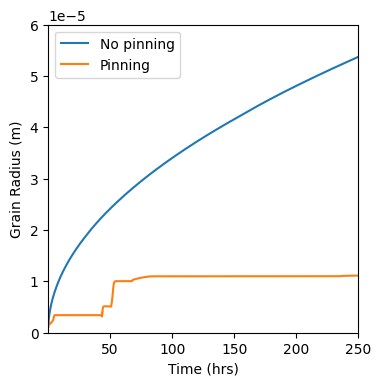

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(t_noPin, r_noPin, label='No pinning')
grainModel.plotRadiusvsTime(ax, timeUnits='h', label='Pinning')
ax.legend()
ax.set_ylim([0, 6e-5])

### Method 2 - Dependent coupling

The next way these two models can be coupled in kawin is by making one model dependent off the other. Here, we'll make the grain growth model dependent off the precipitate model.

Implementation-wise, this requires the grain growth model to have a function called "updateCoupledModel" which will take the precipitate model as an input.

This type of coupling is similar to method 1, except that instead of running each model for a fixed amount of time, the precipitate model will first update a single iteration. Then the grain growth model will be solved for the amount of time that was solved for in that iteration. You can think of it as method 1, but with much finer intervals of time that are determined by the precipitate model.

In [5]:
#Reset models
precModel.reset()
grainModel.reset()

#Add grain growth model to the precipitate model to be updated every iteration
precModel.addCouplingModel(grainModel)

precModel.solve(9e5, verbose=True, vIt=2000)

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
0	0.0e+00		0.0		673		0.2000

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	0.000e+00		0.0000		0.0000e+00	3.6624e+03

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
2000	4.0e+02		10.3		673		0.1605

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	2.474e+20		0.1590		1.1460e-08	3.3350e+03

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
3789	9.0e+05		21.5		673		0.0165

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	7.215e+19		0.7344		2.8293e-08	8.2106e+01



(0.0, 6e-05)

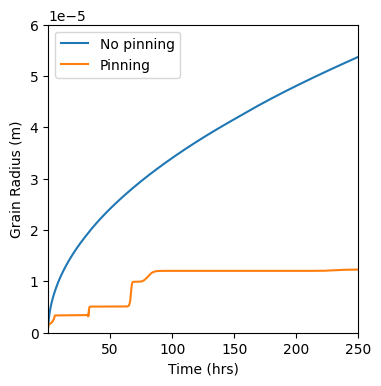

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(t_noPin, r_noPin, label='No pinning')
grainModel.plotRadiusvsTime(ax, timeUnits='h', label='Pinning')
ax.legend()
ax.set_ylim([0, 6e-5])

### Method 3 - Tight coupling

kawin supplies a Coupler class that allows control over how the models affect each other within a single iteration when solving. This can enable tigher coupling between multiple models.

Here, we'll create a custom model class that inherits the Coupler. We can then overload the getdXdt function to compute the Zener radius of the grain growth model using the current particle size distribution of the precipitate model. (Note: we use the parameter x in the getdXdt function rather than using the particle size distribution from the precipitate model itself since x is the most recent values of the model. For iteration schemes that have multiple steps such as the Runga Kutta methods, x will include the intermediate values generated during the iteration).

In [7]:
from kawin.GenericModel import Coupler

class CustomCoupledModel(Coupler):
    def __init__(self, precModel, grainModel):
        '''
        Custom model that inherits the coupler
        The coupler takes a list of models, but we can separate them
            in this derived class
        '''
        self.precModel = precModel
        self.grainModel = grainModel
        super().__init__([precModel, grainModel])

    def getdXdt(self, t, x):
        '''
        Here we overload the getdXdt function by computing the zener
        radius in the grain growth model before compute dXdt for the two
        models
        '''
        self.grainModel.computeZenerRadiusByN(self.precModel, x[0])
        return super().getdXdt(t, x)
    
#Reset models
precModel.reset()
precModel.clearCouplingModels()
grainModel.reset()

#Create the coupled model and solve
coupledModel = CustomCoupledModel(precModel, grainModel)
coupledModel.solve(9e5, verbose=True, vIt=2000)

Iteration	Sim Time(s)	Run Time(s)
0		0.0e+00		0.0
2000		2.7e+02		11.1
4000		1.3e+03		21.0
6000		1.7e+04		38.1
8000		2.6e+05		47.3
9790		9.0e+05		55.8


(0.0, 6e-05)

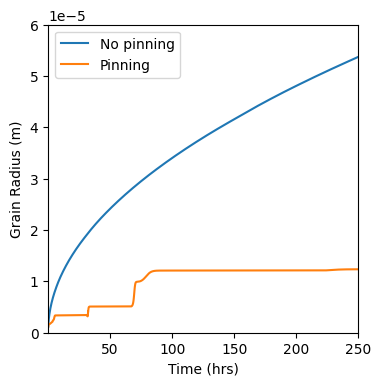

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(t_noPin, r_noPin, label='No pinning')
grainModel.plotRadiusvsTime(ax, timeUnits='h', label='Pinning')
ax.legend()
ax.set_ylim([0, 6e-5])